*Copyright (C) 2022 Intel Corporation*<br>
*SPDX-License-Identifier: BSD-3-Clause*<br>
*See: https://spdx.org/licenses/*

---

# Excitatory-Inhibitory Neural Network with Lava

**Motivation**: In this tutorial, we will build a Lava Process for a neural networks of excitatory and inhibitory neurons (E/I network). <br>
E/I networks are a fundamental example of neural networks mimicking the structure of the brain and exhibiting rich dynamical behavior. <br>

#### This tutorial assumes that you:
- have the [Lava framework installed](../in_depth/tutorial01_installing_lava.ipynb "Tutorial on Installing Lava")
- are familiar with the [Process concept in Lava](../in_depth/tutorial02_processes.ipynb "Tutorial on Processes")

#### This tutorial gives a high level view of
- how to implement simple E/I Network Lava Process
- hot to define and select multiple ProcessModels for the E/I Network, based on Rate and [Leaky Integrate-and-Fire (LIF)](https://github.com/lava-nc/lava/tree/main/src/lava/proc/lif "Lava's LIF neuron") neurons
- how to use tags to chose between different ProcessModels when running the Process
- the principle adjustments needed to run bit-accurate ProcessModels

#### E/I Network
From bird's-eye view, an E/I network is a recurrently coupled network of neurons.<br>
Since positive couplings (excitatory synapses) alone lead to a positive feedback loop ultimately causing a divergence in the activity of the network, appropriate negative couplings (inhibitory synapses) need to be introduced to counterbalance this effect.<br>
We here require a separation of the neurons into two populations: Neurons can either be inhibitory or excitatory. <br>
Such networks exhibit different dynamical states. By introducing a control parameter, we can switch between these states and simultaneously alter the response properties of the network. <br>
In the notebook below, we introduce two incarnations of E/I networks with different single neuron models: Rate and LIF neurons. <br>
By providing a utility function that maps the weights from rate to LIF networks, we can retain hallmark properties of the dynamic in both networks.
<br>
Technically, the abstract E/I network is implemented via a LavaProcess, the concrete behavior - Rate and LIF dynamics - is realized with different ProcessModels.<br>

#### General imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt

#### E/I Network Lava Process
We define the structure of the E/I Network Lava Process class. <br>

In [2]:
# Import Process level primitives
from lava.magma.core.process.process import AbstractProcess
from lava.magma.core.process.variable import Var
from lava.magma.core.process.ports.ports import InPort, OutPort

In [3]:
class EINetwork(AbstractProcess):
    """Network of recurrently connected neurons.
    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
        shape_exc = kwargs.pop("shape_exc", (1,))
        bias_exc = kwargs.pop("bias_exc", 1)
        shape_inh = kwargs.pop("shape_inh", (1,))
        bias_inh = kwargs.pop("bias_inh", 1)
        # Factor controlling strength of inhibitory synapses relative to excitatory synapses.
        self.g_factor = kwargs.pop("g_factor", 4)
        # Factor controlling response properties of network.
        # Larger q_factor implies longer lasting effect of provided input.
        self.q_factor = kwargs.pop("q_factor", 1)
        weights = kwargs.pop("weights")
        
        full_shape = shape_exc + shape_inh
        
        self.state = Var(shape=(full_shape,), init=0)
        # Variable for possible alternative state.
        self.state_alt = Var(shape=(full_shape,), init=0)
        # Biases provided to neurons.
        self.bias_exc = Var(shape=(shape_exc,), init=bias_exc)
        self.bias_inh = Var(shape=(shape_inh,), init=bias_inh)
        self.weights = Var(shape=(full_shape, full_shape), init=weights)

        # Ports for receiving input or sending output.
        self.inport = InPort(shape=(full_shape,))
        self.outport = OutPort(shape=(full_shape,))

#### ProcessModels for Python execution

In [4]:
# Import parent classes for ProcessModels for Hierarchical Processes.
from lava.magma.core.model.py.model import PyLoihiProcessModel
from lava.magma.core.model.sub.model import AbstractSubProcessModel

# Import execution protocol.
from lava.magma.core.sync.protocols.loihi_protocol import LoihiProtocol

# Import decorators..
from lava.magma.core.decorator import implements, tag, requires

### Rate neurons
We next turn to the different implementations of the E/I Network.
We start with a rate network obeying the equation
\begin{equation}
    \tau\dot{r} =  -r + W \phi(r) + I_{\mathrm{bias}}.
\end{equation}
The rate or state $r$ is a vector containing the excitatory and inhibitory populations. <br>
The non-linearity $\phi$ is chosen to be the error function. <br> 
The dynamics consists of a dampening part ($-r$), a part modelling the recurrent connectivity ($ W \phi(r)$)
 and an external bias ($I_{\mathrm{bias}})$. <br>
 We discretize the equation as follows:
 \begin{equation}
    r(i + 1) = (1 - dr) \odot r(i) + W \phi(r(i)) \odot dr + I_{\mathrm{bias}} \odot dr
\end{equation}
Potentially different time scales in the neuron dynamics of excitatory and inhibitory neurons as well as different bias currents for these subpopulations are encoded in the vectors $dr$ and $I_{\mathrm{bias}}$. We use the error function as non-linearity $\phi$.

In [5]:
from lava.magma.core.model.py.type import LavaPyType
from lava.magma.core.model.py.ports import PyInPort, PyOutPort
from lava.magma.core.resources import CPU
from lava.magma.core.model.model import AbstractProcessModel

from scipy.special import erf

@implements(proc=EINetwork, protocol=LoihiProtocol)
@tag('rate_neurons') # Tag allows for easy selection of ProcessModel in case multiple are defined.
@requires(CPU)
class RateEINetworkModel(PyLoihiProcessModel):

    outport: PyOutPort = LavaPyType(PyOutPort.VEC_DENSE, float)
    inport: PyInPort = LavaPyType(PyInPort.VEC_DENSE, float)    
    state : np.ndarray = LavaPyType(np.ndarray, float)
    state_alt : np.ndarray = LavaPyType(np.ndarray, float)
    bias_exc : np.ndarray = LavaPyType(np.ndarray, float)
    bias_inh : np.ndarray = LavaPyType(np.ndarray, float)
    weights : np.ndarray = LavaPyType(np.ndarray, float)

    def __init__(self, proc):
        super().__init__(proc_params=proc)
        
        self.dr_exc = proc.get('dr_exc')
        self.dr_inh = proc.get('dr_inh')
        
        self.shape_exc = proc.get('shape_exc')
        self.shape_inh = proc.get('shape_inh')
        
        self.proc = proc
        
        self.got_decay = False
        self.got_bias = False
        self.weights_scaled = False
        
    def get_decay(self):
        '''Construct decay factor.
        '''
        dr_full = np.array([self.dr_exc] * self.shape_exc + [self.dr_inh] * self.shape_inh)
        self.decay = 1 - dr_full
        
        self.got_decay= True
        
    def get_bias(self):
        '''Construce biases.
        '''
        self.bias_full = np.hstack([self.bias_exc, self.bias_inh])
        self.got_bias = False 
        
    def scale_weights(self):
        '''Scale the weights with integration time step.
        '''
        
        self.weights[:, self.shape_exc:] *= self.dr_exc
        self.weights[:, :self.shape_exc] *= self.dr_inh
        self.proc.overwrite('weights', self.weights)
        
        self.weights_scaled = True
        
    def state_update(self, state):
        """Update network state according to:
            r[i + 1] = (1 - dr)r[i] + Wr[i]*r*dr + bias*dr
        """
        state_new = self.decay * state # Decay the state.
        state_new += self.bias_full # Add the bias.
        state_new += self.weights @ erf(state) # Add the recurrent input.
        return state_new
    
    def run_spk(self):
        """The run function that performs the actual computation during
        execution orchestrated by a PyLoihiProcessModel using the
        LoihiProtocol.
        """
        
        if not self.got_decay:
            self.get_decay()
            
        if not self.got_bias:
            self.get_bias()
            
        if not self.weights_scaled:
            self.scale_weights()
        
        a_in = self.inport.recv()
        self.state = self.state_update(self.state) + a_in
        self.outport.send(self.state)
        

#### Defining the parameters for the network
Next, we need to constrain the network with the needed parameters. <br>
First, we define the dimensionality of the network which we identify with the total number of neurons as well as the single neuron parameters.<br>
We here follow the common choice that the ratio between the number of excitatory and inhibitory neurons equals $4$ and that the connection probability between two arbitrary neurons is identical. <br>
The recurrent weights must *balance* the network, i.e. the average recurrent input to a neuron must be less or equal than $0$.<br>
This implies that we need to increase the strength of the inhibitory weights, the `g_factor`, to at least $4$. We choose $4.5$ to unambiguously place the network in the inhibition dominated regime. <br>
Finally, we set a parameter that controls the response properties of the network by scaling up the recurrent weights, the `q_factor`.

In [6]:
# Fix the randomness.
np.random.seed(1234)

# Define dimensionality of the network.
dim = 400
shape = (dim,)

# We represent the dimensionality by 400 neurons. As stated above 80% of the neurons will be excitatory.
num_neurons_exc = int(dim * 0.8)
num_neurons_inh = dim - num_neurons_exc

# Single neuron paramters. Bias_mant is set to make the neuron spike.
params_exc = {
    "shape_exc": num_neurons_exc,
    "dr_exc": 0.01,
    "bias_exc": 0.1}

params_inh = {
    "shape_inh": num_neurons_inh,
    "dr_inh": 0.01,
    "bias_inh": 0.1}

# Inhibition-exciation balance for scaling inhibitory weights to maintain balance (4 times as many excitatory neurons).
g_factor = 4.5

# Factor controlling the response properties.
q_factor = 1

# Parameters Paramters for E/I network.
network_params_balanced = {}

network_params_balanced.update(params_exc)
network_params_balanced.update(params_inh)
network_params_balanced['g_factor'] = g_factor
network_params_balanced['q_factor'] = q_factor

Finally, we have to set the weights given the above constraints. To this end, we sample the weights randomly from a Gaussian distribution with zero-mean and a standard deviation that scales with the ```q_factor```.

In [7]:
def generate_gaussian_weights(dim, num_neurons_exc, q_factor, g_factor):
    '''Generate connectivity drawn from a Gaussian distribution with mean 0
    and std of (2 * q_factor) ** 2  / dim.
    If a excitatory neuron has a negative weight, we set it to 0 and similarly adapt
    positive weights for inhibitory neurons.
    W[i, j] is connection weight from pre-synaptic neuron j to post-synaptic neuron i.
    
    Paramerters
    -----------
    dim : int
        Dimensionality of network
    num_neurons_exc : int
        Number of excitatory neurons
    q_factor : float
        Factor determining response properties of network
    g_factor : float
        Factor determining inhibition-excitation balance
    '''
    # Set scaled standard deviation of recurrent weights.
    #J = q_factor**2 * 6 / full_shape
    J = (2 * q_factor)**2 / dim
    weights = np.random.normal(0, J,
                                   (dim, dim))
        
    # Impose constraint that neurons can **either** be excitatory (positive weight)
    # **or** inhibitory (negative weight).
    exc_conns = np.full(weights.shape, True)
    exc_conns[:, num_neurons_exc:] = False # Set entries for inhibitory neurons to False.
    inh_conns = np.invert(exc_conns)
            
    mask_pos_weights = (weights > 0)
    mask_neg_weights = (weights < 0)

    # Set negative weights of exciatory neurons to zero and similarly for inhibitory neurons.
    # This induce sparsity in the connectivity.
    weights[mask_neg_weights * exc_conns] = 0
    weights[mask_pos_weights * inh_conns] = 0

    # We finally need to increase the inhibitory weights by a factor to control balance.
    weights[inh_conns] *= g_factor
            
    return weights

# Generate weights
network_params_balanced['weights'] = generate_gaussian_weights(dim,
                                                               num_neurons_exc,
                                                               network_params_balanced['q_factor'],
                                                               network_params_balanced['g_factor'])

#### Execution and Results

In [8]:
from lava.magma.core.run_conditions import RunSteps
from lava.magma.core.run_configs import Loihi1SimCfg
# Import io processes.
from lava.proc.io import sink, source
from lava.proc.monitor.process import Monitor

# Configurations for execution.
num_steps = 750
rcfg = Loihi1SimCfg(select_tag='rate_neurons')
run_cond = RunSteps(num_steps=num_steps)

# Instantiating network and IO processes.
network_balanced = EINetwork(**network_params_balanced)
state_monitor = Monitor()

state_monitor.probe(target=network_balanced.state,  num_steps=num_steps)

# Run the network.
network_balanced.run(run_cfg=rcfg, condition=run_cond)
states_balanced = state_monitor.get_data()[network_balanced.name][network_balanced.state.name]
network_balanced.stop()

#### Visualizing the activity
We first have a look at the activity of the network by plotting the numerical value of the state of the first $50$ neurons.

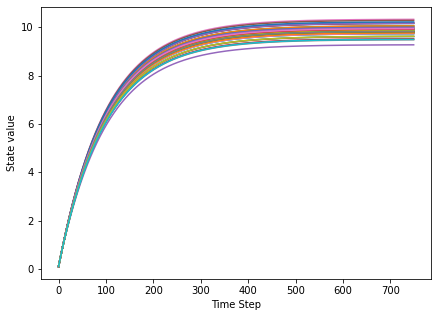

In [9]:
plt.figure(figsize=(7,5))
plt.xlabel('Time Step')
plt.ylabel('State value')
plt.plot(states_balanced[:, :50])
plt.show()

We observe that after an initial period the network settles in a fixed point.<br>
As it turns out, this is a global stable fixed point of the network dynamics: If we applied a small perturbation, the network would return to the stable state.<br>
Such a network is unfit for performing meaningful computations, the dynamics is low-dimensional and rather poor.<br>
To better understand this, we apply an additional analysis.

#### Further analysis
We introduce the *auto-correlation function* $c(\tau)$. <br>
With this function, one can assess the *memory* of the network as well as the richness of the dynamics. <br>
Denoting the (temporally averaged) network activity by $a$, the *auto-covariance function* is the variance (here denoted $\mathrm{Cov}(\cdot, \cdot)$) of $a$ with a time shifted version of itself:
\begin{equation}
    c(\tau) = \mathrm{Cov}(a(t), a(t+\tau))
\end{equation}
This means for positive $\tau$ the value of the auto-covariance function gives a measure for the similarity of the network state $a(t)$ and $a(t+\tau)$. <br>
By comparing $c(\tau)$ with $c(0)$, we may assess the *memory* a network has of its previous states after $\tau$ time steps.<br>
Note that the auto-covariance function is not normalised!<br>
Due to this, we may derive further information about the network state: If $c(0)$ is small (in our case $<< 1$), the network activity is not rich and does not exhibit a large temporal variety across neurons. Thus the networks is unable to perform meaningful computations.

In [10]:
def auto_cov_fct(acts, max_lag=100, offset=200):
    """Auto-correlation function of parallel spike trains.
    
    Parameters
    ----------
    
    acts : np.ndarray shape (timesteps, num_neurons)
        Activity of neurons, a spike is indicated by a one    
    max_lag : int
        Maximal lag for compuation of auto-correlation function
        
    Returns:
    
    lags : np.ndarray
        lags for auto-correlation function
    auto_corr_fct : np.ndarray
        auto-correlation function
    """
    acts = acts[offset:] # Disregard time steps at beginning due to network not being settled yet.
    assert max_lag < acts.shape[0], 'Maximal lag must be smaller then total number of time points'
    num_neurons = acts.shape[1]
    acts -= np.mean(acts, axis=0) # Perform temporal averaging.
    auto_corr_fct = np.zeros(2 * max_lag + 1)
    lags = np.linspace(-1 * max_lag, max_lag, 2 * max_lag + 1, dtype=int)
    
    for i, lag in enumerate(lags):
        shifted_acts = np.roll(acts, shift=lag, axis=0)
        auto_corrs = np.zeros(acts.shape[0])
        for j, act in enumerate(acts):
            auto_corrs[j] = np.dot(act - np.mean(act),
                                   shifted_acts[j] - np.mean(shifted_acts[j]))/num_neurons
        auto_corr_fct[i] = np.mean(auto_corrs)
        
    return lags, auto_corr_fct

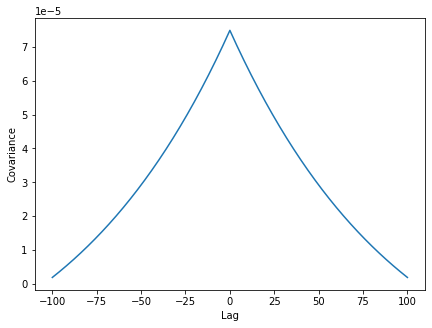

In [11]:
lags, ac_fct_balanced = auto_cov_fct(acts=states_balanced)

# Plotting the auto-correlation function.
plt.figure(figsize=(7,5))
plt.xlabel('Lag')
plt.ylabel('Covariance')
plt.plot(lags, ac_fct_balanced)
plt.show()

As expected, there is covariance has its maximum at a time lag of $0$. <br>
Examining the covariance function, we first note its values are small ($<<1$) implying low dimensional dynamics of the network. <br>
This fits our observation made above on the grounds of the display of the time-resolved activity. <br>

#### Controlling the network
We saw that the states of the neurons quickly converged to a globally stable fixed point.<br>
The reason for this fixed point is, that the dampening part dominates the dynamical behavior - we need to increase the weights! <br>
This we can achieve by increasing the `q_factor`.

In [12]:
# Defining new, larger q_factor.
q_factor = np.sqrt(dim / 6)

# Changing the strenghts of the recurrent connections.
network_params_critical = network_params_balanced.copy()
network_params_critical['q_factor'] = q_factor
network_params_critical['weights'] = generate_gaussian_weights(dim,
                                                               num_neurons_exc,
                                                               network_params_critical['q_factor'],
                                                               network_params_critical['g_factor'])


# Configurations for execution.
num_steps = 750
rcfg = Loihi1SimCfg(select_tag='rate_neurons')
run_cond = RunSteps(num_steps=num_steps)

# Instantiating network and IO processes.
network_critical = EINetwork(**network_params_critical)
state_monitor = Monitor()

state_monitor.probe(target=network_critical.state,  num_steps=num_steps)

# Run the network.
network_critical.run(run_cfg=rcfg, condition=run_cond)
states_critical = state_monitor.get_data()[network_critical.name][network_critical.state.name]
network_critical.stop()

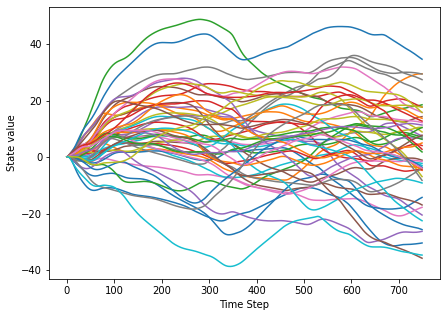

In [13]:
plt.figure(figsize=(7,5))
plt.xlabel('Time Step')
plt.ylabel('State value')
plt.plot(states_critical[:, :50])
plt.show()

We find that after increasing the `q_factor`, the network shows a very different behavior. The stable fixed point is gone, instead we observe chaotic network dynamics: <br>
The single neuron trajectories behave unpredictably and fluctuate widely, a small perturbation would lead to completely different state.

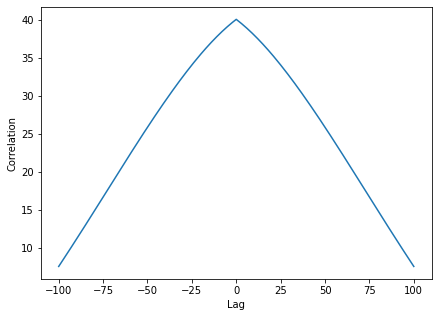

In [14]:
lags, ac_fct_critical = auto_cov_fct(acts=states_critical)

# Plotting the auto-correlation function.
plt.figure(figsize=(7,5))
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.plot(lags, ac_fct_critical)
plt.show()

We moreover see that for positive time lags the auto-covariance function still is large. <br>
This means that the network has memory of its previous states: The state at a given point in time influences strongly the subsequent path of the trajectories of the neurons. <br>
Such a network can perform meaningful computations.

### LIF Neurons
We now turn to a E/I networks implementing its dynamic behavior with leaky integrate-and-fire neurons. <br>
For this, we harness the concepts of Hierarchical Lava Processes and SubProcessModels. These allow us to avoid implementing everything ourselves, but rather to use already defined Processes and their ProcessModels to build more complicated programs. <br>
We here use the behavior defined for the [LIF](https://github.com/lava-nc/lava/tree/main/src/lava/proc/lif "Lava's LIF neuron") and [Dense](https://github.com/lava-nc/lava/tree/main/src/lava/proc/dense "Lava's Dense Connectivity") Processes, we define the behavior of the E/I Network Process. <br>
Moreover, we would like to place the LIF E/I network in a similar dynamical regime as the rate network. This is a difficult task since the underlying single neurons dynamics are quite different. We here provide an approximate conversion function that allows for a parameter mapping and especially qualitatively retains properties of the auto-covariance function. <br>
With the implementation below, we may either pass LIF specific parameters directly  **or** use the same parameters needed for instantiating the rate E/I network and then convert them automatically.<br>

In [15]:
from lava.proc.dense.process import Dense
from lava.proc.lif.process import LIF
from convert_params import convert_rate_to_lif_params

@implements(proc=EINetwork, protocol=LoihiProtocol)
@tag('lif_neurons')
class SubEINetworkModel(AbstractSubProcessModel):
    def __init__(self, proc):
        
        convert = proc.proc_params.get('convert', False)
        
        if convert:
            proc_params = proc.proc_params._parameters
            # Convert rate parameters to LIF parameters.
            # The mapping is based on:
            # A unified view on weakly correlated recurrent network, Grytskyy et al., 2013
            lif_params = convert_rate_to_lif_params(**proc_params)
            
            for key, val in lif_params.items():
                try:
                    proc.proc_params.__setitem__(key, val)
                except KeyError:
                    if key == 'weights':
                        # weights need to be updated
                        proc.proc_params._parameters[key] = val
                    else:
                        continue
                
        # Fetch values for excitatory neurons or set default.
        shape_exc = proc.proc_params.get('shape_exc')
        shape_inh = proc.proc_params.get('shape_inh')
        du_exc = proc.proc_params.get('du_exc')
        dv_exc = proc.proc_params.get('dv_exc')
        vth_exc = proc.proc_params.get('vth_exc')
        bias_mant_exc = proc.proc_params.get('bias_mant_exc')
        bias_exp_exc = proc.proc_params.get('bias_exp_exc', 0)
        
        
        # Fetch values for inhibitory neurons or set default.
        du_inh = proc.proc_params.get('du_inh')
        dv_inh = proc.proc_params.get('dv_inh')
        vth_inh = proc.proc_params.get('vth_inh')
        bias_mant_inh = proc.proc_params.get('bias_mant_inh')
        bias_exp_inh = proc.proc_params.get('bias_exp_inh', 0)
        
        # Create parameters for full network.
        du_full = np.array([du_exc] * shape_exc
                           + [du_inh] * shape_inh)
        dv_full = np.array([dv_exc] * shape_exc
                           + [dv_inh] * shape_inh)
        vth_full = np.array([vth_exc] * shape_exc 
                            + [vth_inh] * shape_inh)
        bias_mant_full = np.array([bias_mant_exc] * shape_exc 
                                  + [bias_mant_inh] * shape_inh)
        bias_exp_full = np.array([bias_exp_exc] * shape_exc +
                                 [bias_exp_inh] * shape_inh)
        weights = proc.proc_params.get('weights')
        weight_exp = proc.proc_params.get('weight_exp', 0)
        
        full_shape = shape_exc + shape_inh

        # Instantiate LIF and Dense Lava Processes.
        self.lif = LIF(shape=(full_shape,),
                       du=du_full,
                       dv=dv_full,
                       vth=vth_full,
                       bias_mant=bias_mant_full,
                       bias_exp=bias_exp_full)

        self.dense = Dense(weights=weights,
                           weight_exp=weight_exp)
            
            
        # Recurrently connect neurons to E/I Network.
        self.lif.s_out.connect(self.dense.s_in)
        self.dense.a_out.connect(self.lif.a_in)

        # Connect incoming activation to neurons and elicited spikes to ouport.
        proc.inport.connect(self.lif.a_in)
        self.lif.s_out.connect(proc.outport)
        
        # Alias v with state and u with state_alt.
        proc.vars.state.alias(self.lif.vars.v)
        proc.vars.state_alt.alias(self.lif.vars.u)

#### Execution and Results
In order to execute the LIF E/I network and the infrastructure to monitor the activity, we introduce a ```CustomRunConfig``` where we specify which ProcessModel we select for execution.

In [16]:
from lava.magma.core.run_conditions import RunSteps
from lava.magma.core.run_configs import Loihi1SimCfg
# Import io processes.
from lava.proc import io

from lava.proc.dense.models import PyDenseModelFloat
from lava.proc.lif.models import PyLifModelFloat


# Configurations for execution.
num_steps = 750
run_cond = RunSteps(num_steps=num_steps)

class CustomRunConfigFloat(Loihi1SimCfg):
    def select(self, proc, proc_models):
        # Customize run config to always use float model for io.sink.RingBuffer.
        if isinstance(proc, io.sink.RingBuffer):
            return io.sink.PyReceiveModelFloat
        if isinstance(proc, LIF):
            return PyLifModelFloat
        elif isinstance(proc, Dense):
            return PyDenseModelFloat
        else:
            return super().select(proc, proc_models)
        
rcfg = CustomRunConfigFloat(select_tag='lif_neurons', select_sub_proc_model=True)

# Instantiating network and IO processes
lif_network_balanced = EINetwork( **network_params_balanced, convert=True)
outport_plug = io.sink.RingBuffer(shape=shape, buffer=num_steps)

# Instantiate Monitors to record the voltage and the current of the LIF neurons.
monitor_v = Monitor()
monitor_u = Monitor()

lif_network_balanced.outport.connect(outport_plug.a_in)
monitor_v.probe(target=lif_network_balanced.state,  num_steps=num_steps)
monitor_u.probe(target=lif_network_balanced.state_alt,  num_steps=num_steps)

lif_network_balanced.run(condition=run_cond, run_cfg=rcfg)

# Fetching spiking activity.
spks_balanced = outport_plug.data.get()
data_v_balanced = monitor_v.get_data()[lif_network_balanced.name][lif_network_balanced.state.name]
data_u_balanced = monitor_u.get_data()[lif_network_balanced.name][lif_network_balanced.state_alt.name]

lif_network_balanced.stop()

#### Visualizing the activity
First, we visually inspect to spiking activity of the neurons in the network.<br>
To this end, we display neurons on the vertical axis and mark the time step when a neuron spiked.

In [17]:
def raster_plot(spks, stride=6, fig=None, color='b', alpha=1):
    """Generate raster plot of spiking activity.
    
    Parameters
    ----------
    
    spks : np.ndarray shape (num_neurons, timesteps)
        Spiking activity of neurons, a spike is indicated by a one    
    stride : int
        Stride for plotting neurons
    """
    num_time_steps = spks.shape[1]
    assert stride < num_time_steps, "Stride must be smaller than number of time steps"
    
    time_steps = np.arange(0, num_time_steps, 1)
    if fig is None:
        fig = plt.figure(figsize=(10,5))
    timesteps = spks.shape[1]
    
    plt.xlim(-1, num_time_steps)
    plt.yticks([])
    
    plt.xlabel('Time steps')
    plt.ylabel('Neurons')
    
    for i in range(0, dim, stride):
        spike_times = time_steps[spks[i] == 1]
        plt.plot(spike_times,
                 i * np.ones(spike_times.shape),
                 linestyle=' ',
                 marker='o',
                 markersize=1.5,
                 color=color,
                 alpha=alpha)
        
    return fig       

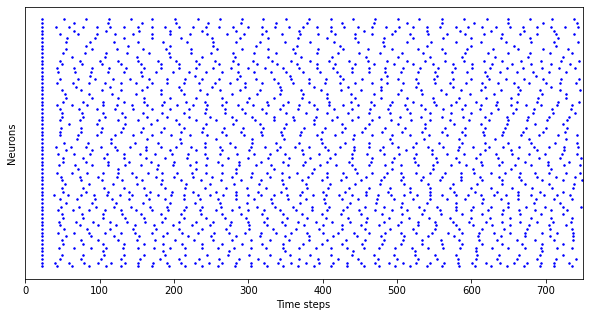

In [18]:
fig = raster_plot(spks=spks_balanced)

After an initial synchronous burst (all neurons are simultaneously driven to the threshold by the external current), we observe an immediate decoupling of the single neuron activities due to the recurrent connectivity.<br>
Overall, we see a heterogeneous network state with asynchronous as well as synchronous spiking across neurons. <br>
This network state resembles qualitatively the fixed point observed above for the rate network. <br>
Before we turn to the study of the auto-covariance we need to address a subtlety in the comparison of spiking and rate network. <br>
Comparing spike trains and rates directly is difficult due dynamics of single spiking neurons: Most of the time, a neuron does not spike! <br>
To overcome this problem and meaningfully compare quantities like the auto-covariance function, we follow the usual approach and bin the spikes. This means, we apply a sliding box-car window of a given length and count at each time step the spikes in that window to obtain an estimate of the rate. <br>

In [19]:
window = np.ones(25) # Window size of 25 time steps for binning.
binned_sps_balanced = np.asarray([np.convolve(spks_balanced[i], window) for i in range(dim)])

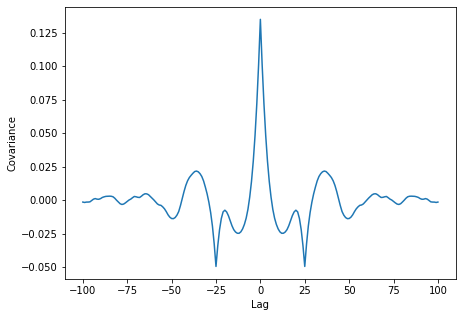

In [20]:
lags, ac_fct = auto_cov_fct(acts=binned_sps_balanced.T)

# Plotting the auto-correlation function.
plt.figure(figsize=(7,5))
plt.xlabel('Lag')
plt.ylabel('Covariance')
plt.plot(lags, ac_fct)

Examining the auto-covariance function, we first note that again the overall values are small. Moreover, we see that for non-vanishing time lags the auto-covariance function quickly decay.<br>
This means that the network has no memory of its previous states: Already after few time step we lost almost all information of the previous network state, former states leave little trace in the overall network activity. <br>
Such a network is unfit to perform meaningful computation.

#### Controlling the network
Next, we pass the rate network parameters for which we increased the `q_factor` to the spiking E/I network.<br>
Dynamically, this increase again should result in a fundamentally different network state.

In [21]:
num_steps = 750
rcfg = CustomRunConfigFloat(select_tag='lif_neurons', select_sub_proc_model=True)
run_cond = RunSteps(num_steps=num_steps)

# Creating new new network with changed weights.
lif_network_critical = EINetwork(**network_params_critical, convert=True)
outport_plug = io.sink.RingBuffer(shape=shape, buffer=num_steps)

# Instantiate Monitors to record the voltage and the current of the LIF neurons.
monitor_v = Monitor()
monitor_u = Monitor()

lif_network_critical.outport.connect(outport_plug.a_in)
monitor_v.probe(target=lif_network_critical.state,  num_steps=num_steps)
monitor_u.probe(target=lif_network_critical.state_alt,  num_steps=num_steps)

lif_network_critical.run(condition=run_cond, run_cfg=rcfg)

# Fetching spiking activity.
spks_critical = outport_plug.data.get()
data_v_critical = monitor_v.get_data()[lif_network_critical.name][lif_network_critical.state.name]
data_u_critical = monitor_u.get_data()[lif_network_critical.name][lif_network_critical.state_alt.name]

lif_network_critical.stop()

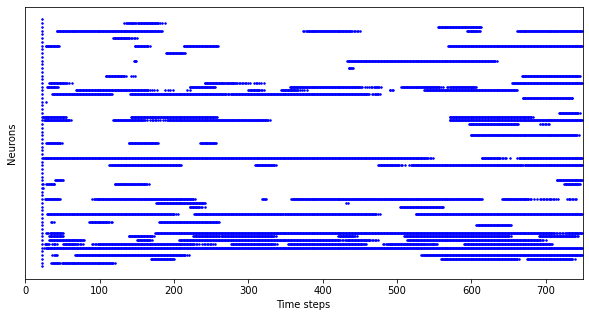

In [22]:
fig = raster_plot(spks=spks_critical)

Here we see a qualitatively different network activity where the recurrent connections play a more dominant role: <br>
At seemingly random times, single neurons enter an active states of variable length. <br>
Next, we have a look at the auto-covariance function of the network, especially in direct comparison with the respective function of the rate network.

In [23]:
window = np.ones(25)
binned_sps_critical = np.asarray([np.convolve(spks_critical[i], window) for i in range(dim)])
lags, ac_fct_lif_critical = auto_cov_fct(acts=binned_sps_critical.T)

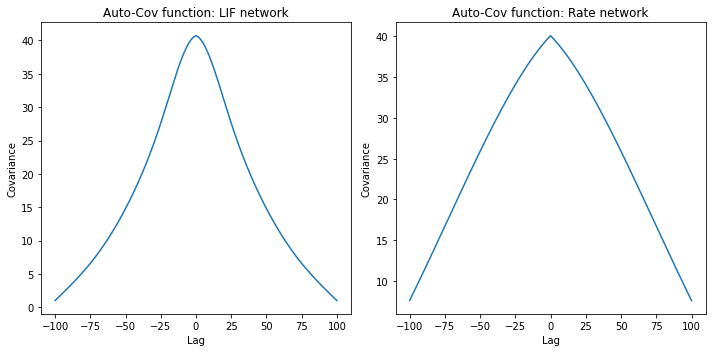

In [24]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.plot(lags, ac_fct_lif_critical)
ax1.set_title('Auto-Cov function: LIF network')
ax1.set_xlabel('Lag')
ax1.set_ylabel('Covariance')
ax2.plot(lags, ac_fct_critical)
ax2.set_title('Auto-Cov function: Rate network')
ax2.set_xlabel('Lag')
ax2.set_ylabel('Covariance')
plt.tight_layout()

We observe in the auto-covariance function of the LIF network a slowly decay, akin to the rate network. <br>
Even though both auto-covariance functions are not identical, they qualitatively match in that both networks exhibit long-lasting temporal correlations and an activity at the edge of chaos. <br>
This implies that both network are in a suitable regime for computation, e.g. in the context of reservoir computing.

#### DIfferent recurrent activation regimes
After having observed these two radically different dynamical states also in the LIF network, we next turn to the question how they come about. <br>
The difference between both version of LIF E/I networks is in the recurrently provided activations. <br>
We now examine these activations by having look at the excitatory, inhibitory as well as total activation provided to each neuron in both networks.

In [25]:
def calculate_activation(weights, spks, num_exc_neurons):
    """Calculate excitatory, inhibitory and total activation to neurons.
    
    Parameters
    ----------
    
    weights : np.ndarray (num_neurons, num_neurons)
        Weights of recurrent connections
    spks : np.ndarray (num_neurons, num_time_steps)
        Spike times of neurons, 0 if neuron did not spike, 1 otherwise
    num_exc_neurons : int
        Number of excitatory neurons
        
    Returns
    -------
    
    activation_exc : np.ndarray (num_neurons, num_time_steps)
        Excitatory activation provided to neurons
    activation_inh : np.ndarray (num_neurons, num_time_steps)
        Inhibitory activation provided to neurons
    activations_total : np.ndarray (num_neurons, num_time_steps)
        Total activation provided to neurons
    """
    
    weights_exc = weights[:, :num_exc_neurons]
    weights_inh = weights[:, num_exc_neurons:]
    
    spks_exc = spks[:num_exc_neurons]
    spks_inh = spks[num_exc_neurons:]
    
    activation_exc = np.matmul(weights_exc, spks_exc)
    activation_inh = np.matmul(weights_inh, spks_inh)
    
    activation_total = activation_exc + activation_inh
    
    return activation_exc, activation_inh, activation_total

Since the network needs some time to settle in it's dynamical state, we discard the first $200$ time steps.

In [26]:
offset = 200

act_exc_balanced, act_inh_balanced, act_tot_balanced \
    = calculate_activation(lif_network_balanced.proc_params.get('weights'),
                          spks_balanced[:,offset:],
                          network_params_balanced['shape_exc'])

act_exc_critical, act_inh_critical, act_tot_critical \
    = calculate_activation(lif_network_critical.proc_params.get('weights'),
                          spks_critical[:,offset:],
                          network_params_balanced['shape_exc'])

First, we look at the distribution of activation of a random neuron in both network states.

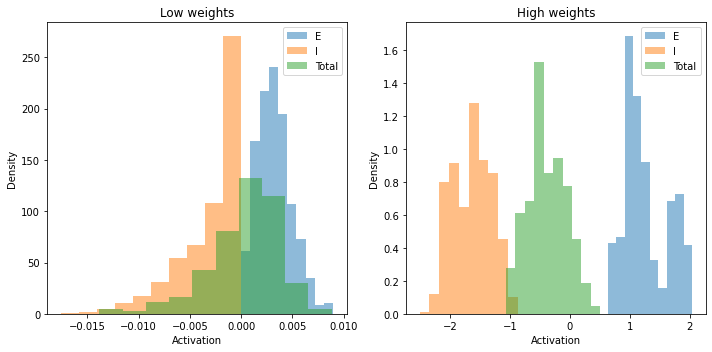

In [27]:
rnd_neuron = 4

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.set_title('Low weights')
ax1.set_xlabel('Activation')
ax1.set_ylabel('Density')
ax1.hist(act_exc_balanced[rnd_neuron], bins=10, alpha=0.5, density=True, label='E')
ax1.hist(act_inh_balanced[rnd_neuron], bins=10, alpha=0.5, density=True, label='I'),
ax1.hist(act_tot_balanced[rnd_neuron], bins=10, alpha=0.5, density=True, label='Total')
ax1.legend()

ax2.set_title('High weights')
ax2.set_xlabel('Activation')
ax2.set_ylabel('Density')
ax2.hist(act_exc_critical[rnd_neuron], bins=10, alpha=0.5, density=True, label='E')
ax2.hist(act_inh_critical[rnd_neuron], bins=10, alpha=0.5, density=True, label='I')
ax2.hist(act_tot_critical[rnd_neuron], bins=10, alpha=0.5, density=True, label='Total')
ax2.legend()

plt.tight_layout()
plt.show()

Next, we plot the distribution of the temporal average:

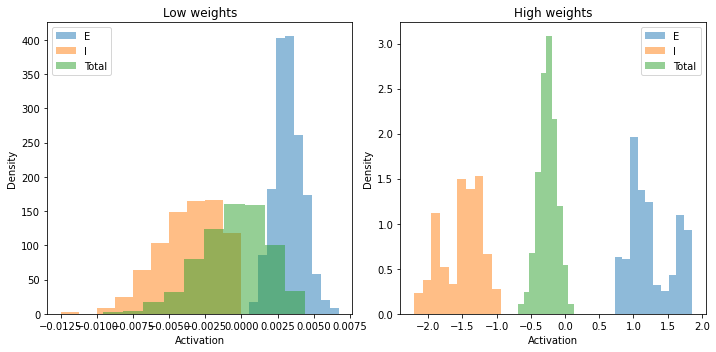

In [28]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.set_title('Low weights')
ax1.set_xlabel('Activation')
ax1.set_ylabel('Density')
ax1.hist(act_exc_balanced.mean(axis=0), bins=10, alpha=0.5, density=True, label='E')
ax1.hist(act_inh_balanced.mean(axis=0), bins=10, alpha=0.5, density=True, label='I'),
ax1.hist(act_tot_balanced.mean(axis=0), bins=10, alpha=0.5, density=True, label='Total')
ax1.legend()

ax2.set_title('High weights')
ax2.set_xlabel('Activation')
ax2.set_ylabel('Density')
ax2.hist(act_exc_critical.mean(axis=0), bins=10, alpha=0.5, density=True, label='E')
ax2.hist(act_inh_critical.mean(axis=0), bins=10, alpha=0.5, density=True, label='I')
ax2.hist(act_tot_critical.mean(axis=0), bins=10, alpha=0.5, density=True, label='Total')
ax2.legend()

plt.tight_layout()
plt.show()

We first note that the the total activation is close to zero with a slight shift to negative values, this prevents the divergence of activity. <br>
Secondly, we observe that the width of the distributions is orders of magnitude larger in the high weight case as compared to the low weight network. <br>
Finally, we look at the evolution of the mean activation over time. To this end we plot three random sample:

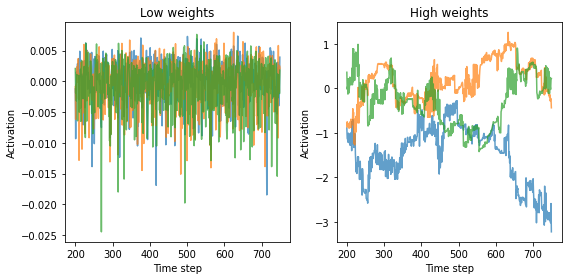

In [29]:
time_steps = np.arange(offset, num_steps, 1)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
ax1.set_title('Low weights')
ax1.set_xlabel('Time step')
ax1.set_ylabel('Activation')
for i in range(3):
    ax1.plot(time_steps, act_tot_balanced[i], alpha=0.7)


ax2.set_title('High weights')
ax2.set_xlabel('Time step')
ax2.set_ylabel('Activation')
for i in range(3):
    ax2.plot(time_steps, act_tot_critical[i], alpha=0.7)

plt.tight_layout()
plt.show()

We see that the temporal evolution of the total activation in the low weights case is much narrower than in the high weights network. <br>
Moreover, we see that in the high weights network, the fluctuations of the activations evolve on a very long time scale as compared to the other network. <br>
This implies that a neuron can sustain it's active, bursting state over longer periods of time leading to memory in the network as well as activity at the edge of chaos.<br>

### Running a ProcessModel bit-accurate with Loihi
So far, we have used neuron models and weights that are internally represented as floating point numbers. <br>
Next, we turn to bit-accurate implementations of the LIF and Dense process where only a fixed precision for the numerical values is allowed. Here, the parameters need to be mapped to retain the dynamical behavior of the network. <br>
First, we define a method for mapping the parameters. It consists of finding an optimal scaling function that consistently maps all appearing floating-point numbers to fixed-point numbers.

In [30]:
def _scaling_funct(params):
    '''Find optimal scaling function for float- to fixed-point mapping.
    
    Parameter
    ---------
    params : dict
        Dictionary containing information required for float- to fixed-point mapping
        
    Returns
    ------
    scaling_funct : callable
        Optimal scaling function for float- to fixed-point conversion
    ''' 
    sorted_params = dict(sorted(params.items(), key=lambda x: np.max(np.abs(x[1]['val'])), reverse=True))
    
    # Initialize scaling function
    scaling_funct = None
    
    for key, val in sorted_params.items(): 
        if val['signed'] == 's':
            signed_shift = 1
        else:
            signed_shift = 0
            
        if np.max(val['val']) == np.max(np.abs(val['val'])):
            max_abs = True
            max_abs_val = np.max(val['val'])
        else:
            max_abs = False
            max_abs_val = np.max(np.abs(val['val']))
            
        if max_abs:
            rep_val = 2**(val['bits'] - signed_shift) - 1
        else:
            rep_val = 2**(val['bits'] - signed_shift)
        
        max_shift = np.max(val['shift'])
        
        max_rep_val = rep_val * 2**max_shift
      
        if scaling_funct:
            scaled_vals = scaling_funct(val['val'])

            max_abs_scaled_vals = np.max(np.abs(scaled_vals))
            if max_abs_scaled_vals <= max_rep_val:
                continue
            else:
                p1 = max_rep_val
                p2 = max_abs_val
        
        else:
            p1 = max_rep_val
            p2 = max_abs_val         
        
        scaling_funct = lambda x: p1 / p2 * x
        
    return scaling_funct

def float2fixed_lif_parameter(lif_params):
    '''Float- to fixed-point mapping for LIF parameters.
    
    Parameters
    ---------
    lif_params : dict
        Dictionary with parameters for LIF network with floating-point ProcModel
        
    Returns
    ------
    lif_params_fixed : dict
        Dictionary with parameters for LIF network with fixed-point ProcModel
    '''
    
    scaling_funct = _scaling_funct(params)
    
    bias_mant_bits = params['bias']['bits']
    scaled_bias = scaling_funct(params['bias']['val'])[0]
    bias_exp = int(np.ceil(np.log2(scaled_bias) - bias_mant_bits + 1))
    if bias_exp <=0:
        bias_exp = 0
    
    
    weight_mant_bits = params['weights']['bits']    
    scaled_weights = np.round(scaling_funct(params['weights']['val']))
    weight_exp = int(np.ceil(np.log2(scaled_bias) - weight_mant_bits + 1))
    weight_exp = np.max(weight_exp) - 6
    if weight_exp <=0:
        diff = weight_exp
        weight_exp = 0

    
    bias_mant = int(scaled_bias // 2**bias_exp)
    weights = scaled_weights.astype(np.int32)
    
    lif_params_fixed = {'vth' : int(scaling_funct(params['vth']['val']) // 2**params['vth']['shift'][0]),
                        'bias_mant': bias_mant,
                        'bias_exp': bias_exp,
                        'weights': np.round(scaled_weights / (2 ** params['weights']['shift'][0])).astype(np.int32),
                        'weight_exp': weight_exp}
    
    return lif_params_fixed

def scaling_funct_dudv(val):
    '''Scaling function for du, dv in LIF
    ''' 
    assert val < 1, 'Passed value must be smaller than 1'
    
    return np.round(val * 2 ** 12).astype(np.int32)

After having defined some primitive conversion functionality we next convert the parameters for the critical network. <br>
To constrain the values that we need to represent in the bit-accurate model, we have to find the dynamical range of the state parameters of the network, namely ```u``` and ```v``` of the LIF neurons.

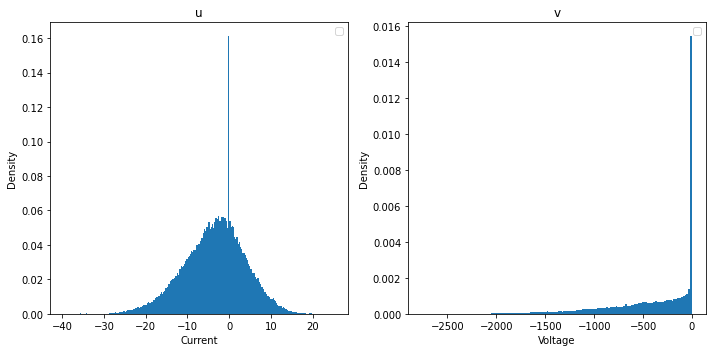

In [31]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.set_title('u')
ax1.set_xlabel('Current')
ax1.set_ylabel('Density')
ax1.hist(data_u_critical.flatten(), bins='auto', density=True)
ax1.legend()

ax2.set_title('v')
ax2.set_xlabel('Voltage')
ax2.set_ylabel('Density')
ax2.hist(data_v_critical.flatten(), bins='auto', density=True)
ax2.legend()

plt.tight_layout()
plt.show()

We note that for both variables the distributions attain large (small) values with low probability. We hence will remove them in the dynamical range to increase the precision of the overall representation. We do so by choosing $0.15$ and $0.85$ quantiles as minimal resp. maximal values for the dynamic ranges.<br>
We finally also need to pass some information about the concrete implementation, e.g. the precision and the bit shifts performed. <br>

In [32]:
u_low = np.quantile(data_u_critical.flatten(), 0.15)
u_high = np.quantile(data_u_critical.flatten(), 0.85)
v_low = np.quantile(data_v_critical.flatten(), 0.15)
v_high = np.quantile(data_v_critical.flatten(), 0.85)

lif_params_critical = convert_rate_to_lif_params(**network_params_critical)
weights = lif_params_critical['weights']
bias = lif_params_critical['bias_mant_exc']

params = {'vth': {'bits': 17, 'signed': 'u', 'shift': np.array([6]), 'val': np.array([1])},
          'u': {'bits': 24, 'signed': 's', 'shift': np.array([0]), 'val': np.array([u_low, u_high])},
          'v': {'bits': 24, 'signed': 's', 'shift': np.array([0]), 'val': np.array([v_low, v_high])},
          'bias': {'bits': 13, 'signed': 's', 'shift': np.arange(0, 3, 1), 'val': np.array([bias])},
          'weights' : {'bits': 8, 'signed': 's', 'shift': np.arange(6,22,1), 'val': weights}}

mapped_params = float2fixed_lif_parameter(params)

Using the mapped parameters, we construct the fully-fledged parameter dictionary for the E/I network Process using the LIF SubProcessModel.

In [33]:
# Set up parameters for bit accurate model
lif_params_critical_fixed = {'shape_exc': lif_params_critical['shape_exc'],
                             'shape_inh': lif_params_critical['shape_inh'],
                             'g_factor': lif_params_critical['g_factor'],
                             'q_factor': lif_params_critical['q_factor'],
                             'vth_exc': mapped_params['vth'],
                             'vth_inh': mapped_params['vth'],
                             'bias_mant_exc': mapped_params['bias_mant'],
                             'bias_exp_exc': mapped_params['bias_exp'],
                             'bias_mant_inh': mapped_params['bias_mant'],
                             'bias_exp_inh': mapped_params['bias_exp'],
                             'weights': mapped_params['weights'],
                             'weight_exp': mapped_params['weight_exp'],
                             'du_exc': scaling_funct_dudv(lif_params_critical['du_exc']),
                             'dv_exc': scaling_funct_dudv(lif_params_critical['dv_exc']),
                             'du_inh': scaling_funct_dudv(lif_params_critical['du_inh']),
                             'dv_inh': scaling_funct_dudv(lif_params_critical['dv_inh'])}

#### Execution of bit accurate model

In [34]:
# Import bit accurate ProcessModels.
from lava.proc.dense.models import PyDenseModelBitAcc
from lava.proc.lif.models import PyLifModelBitAcc

# Configurations for execution.
num_steps = 750
run_cond = RunSteps(num_steps=num_steps)

# Define custom Run Config for execution of bit accurate models.
class CustomRunConfigFixed(Loihi1SimCfg):
    def select(self, proc, proc_models):
        # Customize run config to always use float model for io.sink.RingBuffer.
        if isinstance(proc, io.sink.RingBuffer):
            return io.sink.PyReceiveModelFloat
        if isinstance(proc, LIF):
            return PyLifModelBitAcc
        elif isinstance(proc, Dense):
            return PyDenseModelBitAcc
        else:
            return super().select(proc, proc_models)
        
rcfg = CustomRunConfigFixed(select_tag='lif_neurons', select_sub_proc_model=True)

lif_network_critical_fixed = EINetwork(**lif_params_critical_fixed)
outport_plug = io.sink.RingBuffer(shape=shape, buffer=num_steps)

lif_network_critical_fixed.outport.connect(outport_plug.a_in)

lif_network_critical_fixed.run(condition=run_cond, run_cfg=rcfg)

# Fetching spiking activity
spks_critical_fixed = outport_plug.data.get()

lif_network_critical_fixed.stop()

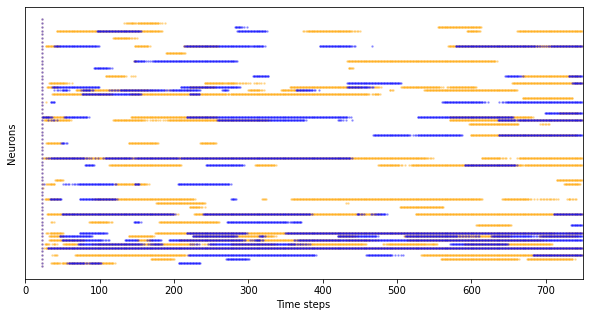

In [35]:
fig = raster_plot(spks=spks_critical, color='orange', alpha=0.3)
raster_plot(spks=spks_critical_fixed, fig=fig, alpha=0.3, color='b')
plt.show()

Comparing the spike times after the parameter conversion, we find that after the first initial time steps, the spike times start diverging, even though certain structural similarities remain. <br>
This, however, is expected: Since the systems is in a chaotic state, slight differences in the variables lead to a completely different output after some time steps. This is generally the behavior in spiking neural network.<br>
**But** the network stays in a *very similar dynamical state* with *similar activity*, as can be seen when examining the auto-covariance function.

In [36]:
window = np.ones(25)
binned_sps_critical_fixed = np.asarray([np.convolve(spks_critical_fixed[i], window) for i in range(dim)])
lags, ac_fct_lif_critical_fixed = auto_cov_fct(acts=binned_sps_critical_fixed.T)

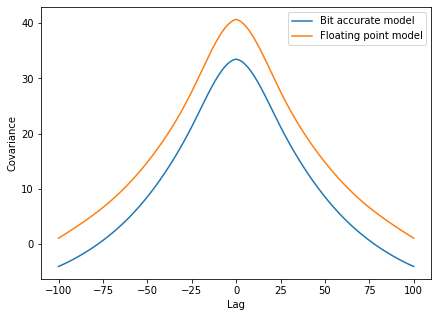

In [37]:
lags, ac_fct = auto_cov_fct(acts=binned_sps_balanced.T)

# Plotting the auto-correlation function.
plt.figure(figsize=(7,5))
plt.xlabel('Lag')
plt.ylabel('Covariance')
plt.plot(lags, ac_fct_lif_critical_fixed, label='Bit accurate model')
plt.plot(lags, ac_fct_lif_critical, label='Floating point model')
plt.legend()
plt.show()

## How to learn more?

#### Follow the links below for deep-dive tutorials on the concepts in this tutorial:
- [Processes](../in_depth/tutorial02_processes.ipynb "Tutorial on Processes")
- [ProcessModel](../in_depth/tutorial03_process_models.ipynb "Tutorial on ProcessModels")
- [Connections](../in_depth/tutorial05_connect_processes.ipynb "Tutorial on Connecting Processe")
- [Execution](../in_depth/tutorial04_execution.ipynb "Tutorial on Executing Processes")
- [SubProcessModels](../in_depth/tutorial06_hierarchical_processes.ipynb) or [Hierarchical Processes](../in_depth/tutorial06_hierarchical_processes.ipynb)

If you want to find out more about Lava, have a look at the [Lava documentation](https://lava-nc.org/ "Lava Documentation") or dive into the [source code](https://github.com/lava-nc/lava/ "Lava Source Code").

To receive regular updates on the latest developments and releases of the Lava Software Framework please subscribe to the [INRC newsletter](http://eepurl.com/hJCyhb "INRC Newsletter").